# Tutorial Exercise 11-1

Assume that we have the following grid world:

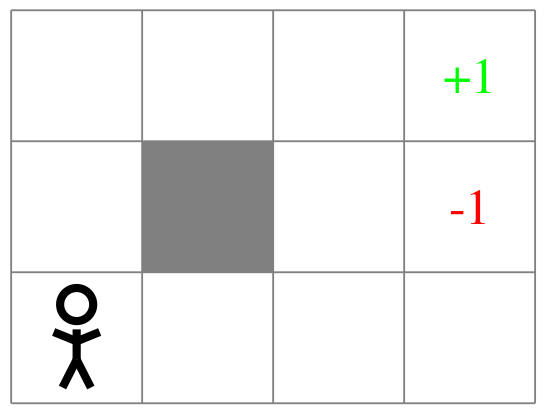

The goal of the agent whose position is at the bottom left corner is to maximize the expected future reward.
The top right (reward +1) and the middle right cell (reward -1) are terminal states.
There are four different actions the agent can choose, namely go up, down, left and right.
However, there is a chance that the agent will result in a wrong grid cell by accident.
If the action is going up, there is a chance of 0.8 that the agent moves up, a chance of 0.1 that he moves left and a chance of 0.1 that he moves right.
All other actions behave accordingly.
If the agent would bounce on a wall it stays at the current position.
Note that the agent cannot move through the grayed-out grid cell.
Assume a gamma value of $\gamma=0.9$.


Assume that the following utility values are given:

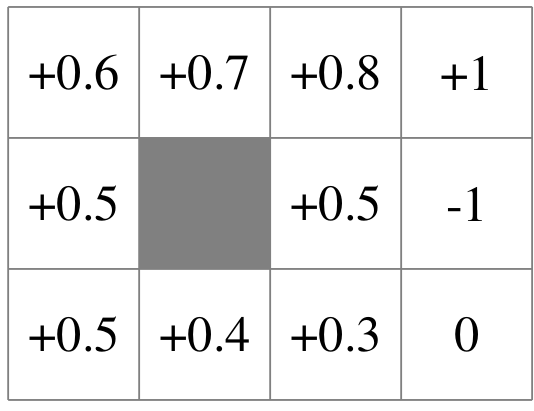

### Environment Definition:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
class MDP:
    
    "0: up, 1: right, 2: left, 3: down"
    _transitions = np.array([
        [[4, 0.8], [-1, 0.1], [1, 0.1]],
        [[1, 0.8], [-4, 0.1], [4, 0.1]],
        [[-1, 0.8], [-4, 0.1], [4, 0.1]],
        [[-4, 0.8], [-1, 0.1], [1, 0.1]]
        ])
    
    def __init__(self, gamma=0.9):
        self.reward = np.zeros(3*4)
        self.reward[-1] = +1
        self.reward[5] = -1
        self.reward[7] = -1
        self.gamma = gamma
        
    def rewards(self, state):
        if state == 12:
            return 0
        return self.reward[state]
    
    def _bounces(self, state, s):
        return np.sum(
            np.abs(np.array(np.where(np.arange(12).reshape((3,4)) == state)) 
                   - np.array(np.where(np.arange(12).reshape((3,4)) == s)))
        ) > 1
    
    def transition(self, state, action):
        if state == 7 or state == 11 or state == 12:
            return np.array([[12, 1]])
        trans = MDP._transitions[action].copy()
        trans = trans.T
        trans[0,:] += state
        trans = trans.T
        for i, (s, prob) in enumerate(trans):
            if s < 0 or s >= 3*4 or s == 5 or self._bounces(state, s):
                trans[i,0] = state
        return trans

In [3]:
def print_utilities(utilities):
    plt.figure()
    reshaped = utilities[0:-1].reshape((3,4))
    reshaped[1,1] = -1
    ax = sns.heatmap(reshaped, annot=True)
    ax.invert_yaxis()

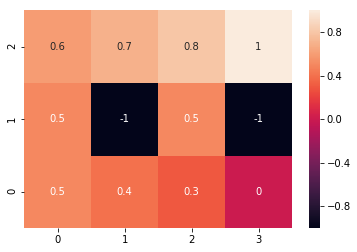

In [4]:
mdp = MDP()

utilities = np.array([0.5,0.4,0.3,0.,0.5,-1.,0.5,-1.,0.6,0.7,0.8,1,0])
print_utilities(utilities)

## Policy Improvement

Implement a policy improvement step in order to compute the policy that is defined by the given utility values.

In [5]:
def q(mdp, state, action, utilities):
    trans = mdp.transition(state, action)
    return mdp.rewards(state) + mdp.gamma * np.dot(utilities[trans.T[0].astype(int)], trans.T[1])

def policy_improvement(mdp, utilities):
    policy = np.zeros(len(utilities))
    for state in range(len(utilities)):
        policy[state] = np.argmax([ q(mdp, state, a, utilities) for a in range(4) ])
    return policy

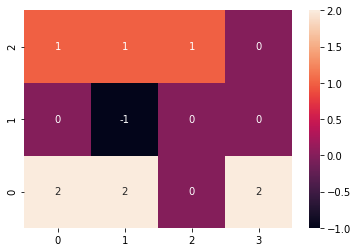

In [6]:
# Prints the computed policy
policy = policy_improvement(mdp, utilities).astype(int)
print_utilities(policy)

## Policy Evaluation

Implement a policy evaluation step in order evaluate the utility values of the improved policy.

In [7]:
def policy_evaluation(mdp, policy):
    states = len(policy)
    reward = [mdp.rewards(s) for s in range(states)]
    prob_matrix = np.eye(states)
    for state in range(states):
        trans = mdp.transition(state, policy[state])
        for i, (s, prob) in enumerate(trans):
            prob_matrix[state,int(s)] -= mdp.gamma * prob
    return np.linalg.solve(prob_matrix, reward)

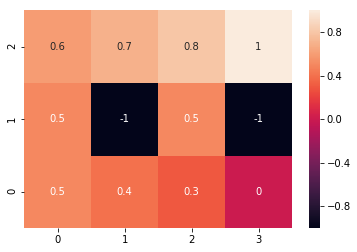

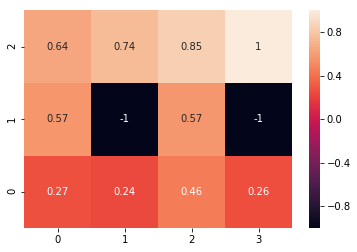

In [8]:
# Prints the starting utilities and the utilities of the improved policy
print_utilities(utilities)
print_utilities(policy_evaluation(mdp, policy))

## Policy Iteration

Implement the policy iteration algorithm by using the policy improvement and evaluation function defined above.

In [9]:
def policy_iteration(mdp):
    policy = np.zeros(13, dtype=int)
    while True:
        utilities = policy_evaluation(mdp, policy)
        next_policy = policy_improvement(mdp, utilities).astype(int)
        if np.sum(next_policy != policy) == 0:
            break
        policy = next_policy
    return policy

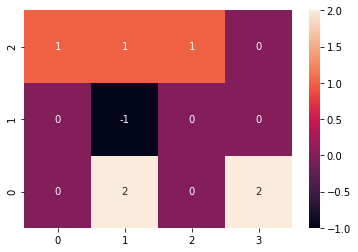

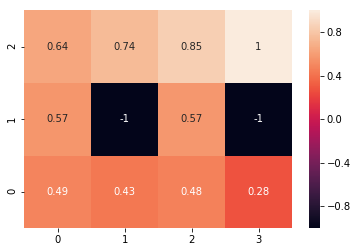

In [10]:
# prints the optimal policy and the optimal utility values
policy = policy_iteration(mdp)
print_utilities(policy)
print_utilities(policy_evaluation(mdp, policy))

## Value Iteration

Implement the value iteration algorithm.

In [11]:
def value_iteration(mdp, utilities):
    utilities_next = np.zeros(len(utilities))

    delta = np.inf
    while delta > 1e-10:
        for state in range(len(utilities)):
            utilities_next[state] = np.max( [ q(mdp, state, a, utilities) for a in range(4) ] )
        delta = np.max(np.abs(utilities - utilities_next))
        utilities = utilities_next.copy()
    return utilities

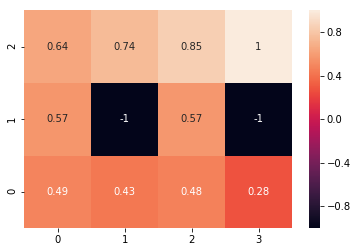

In [12]:
# prints the optimal utility from Value Iteration
optimal = value_iteration(mdp, utilities)
print_utilities(optimal)